# SG-MCMC Sampling - Hands-on
This notebook implements sgmcmc samplers to test them on simple landscapes. So we are able to get a feeling for their differences and behavior.

In [30]:
import jax.numpy as jnp
import os
import matplotlib.pyplot as plt

from enhancing_sgmcmc.samplers.sghmc import SGHMC
from enhancing_sgmcmc.utils import (
    gaussian_mixture_logprob,
    generate_gmm_data,
    gmm_grad_estimator,
    run_sequential_sghmc,
    plot_gmm_sampling,
    compute_fisher_diagonal,
)
from enhancing_sgmcmc.metrics import compute_metrics

In [2]:
os.chdir("..")

In [3]:
%load_ext autoreload
%autoreload 2

### Setup

In [97]:
seed = 2

In [98]:
means = jnp.array([[0, 0]])
covs = jnp.array([[[5, 0], [0, 0.2]]])
weights = jnp.array([1])
data_samples = 1000

In [99]:
sampler = SGHMC(gmm_grad_estimator)
init_position = jnp.array([1.0, 1.0])

samples = generate_gmm_data(
    seed=seed, means=means, covs=covs, weights=weights, n_samples=data_samples
)

In [100]:
prec_identity = jnp.array([1, 1])
prec_fisher = compute_fisher_diagonal(
    position=init_position,
    data=samples,
)
step_size = 0.05
mdecay = 0.02
burnin = 0
n_batches = 5
mcmc_samples = 500

In [101]:
trajectory_identity = run_sequential_sghmc(
    sampler=sampler,
    data=samples,
    init_position=init_position,
    init_m=prec_identity,
    batch_size=len(samples) // n_batches,
    mcmc_samples=mcmc_samples,
    step_size=step_size,
    mdecay=mdecay,
    seed=seed,
)

In [102]:
trajectory_fisher = run_sequential_sghmc(
    sampler=sampler,
    data=samples,
    init_position=init_position,
    init_m=prec_fisher,
    batch_size=len(samples) // n_batches,
    mcmc_samples=mcmc_samples,
    step_size=step_size,
    mdecay=mdecay,
    seed=seed,
)

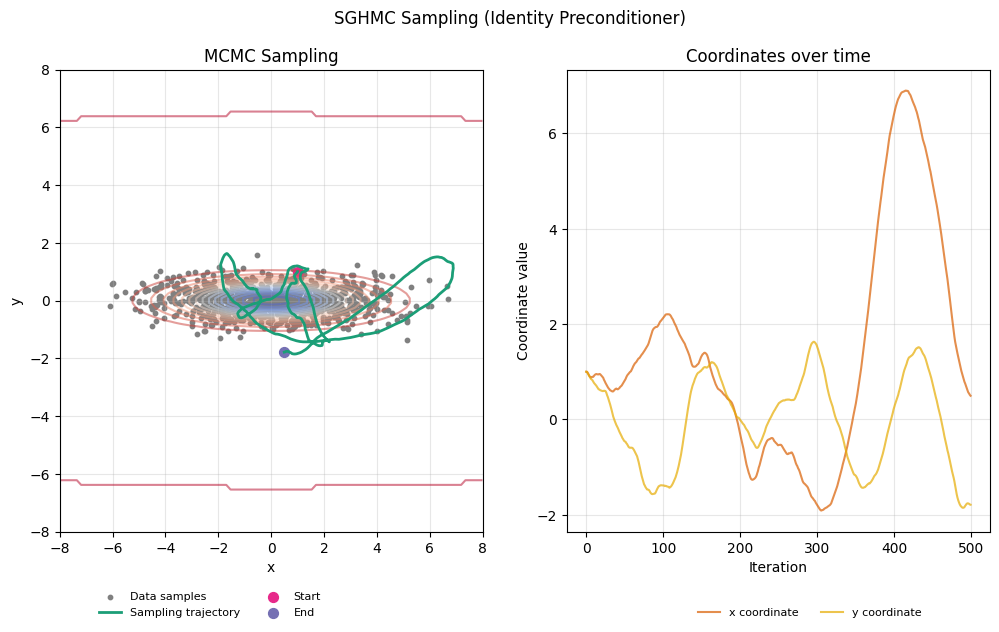

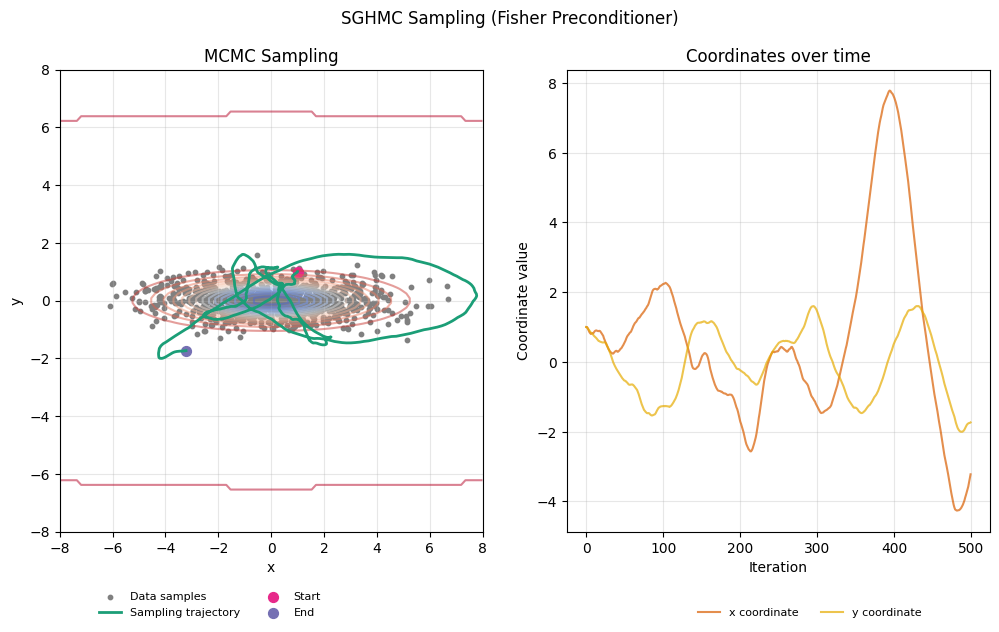

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_gmm_sampling(
    fig=fig,
    ax=ax,
    trajectory=trajectory_identity,
    samples=samples,
    means=means,
    covs=covs,
    weights=weights,
    title="SGHMC Sampling (Identity Preconditioner)",
    burnin=burnin,
    plot_type="both",
    xlim=(-8, 8),
    ylim=(-8, 8),
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_gmm_sampling(
    fig=fig,
    ax=ax,
    trajectory=trajectory_fisher,
    samples=samples,
    means=means,
    covs=covs,
    weights=weights,
    title="SGHMC Sampling (Fisher Preconditioner)",
    burnin=burnin,
    plot_type="both",
    xlim=(-8, 8),
    ylim=(-8, 8),
)

In [116]:
compute_metrics(
    samples=trajectory_identity,
    true_samples=samples,
    means=means,
    covs=covs,
    weights=weights,
    metrics=["nll", "ksd", "ess", "wasserstein"],
)

{'wasserstein': 1.3632571608468425e-05,
 'nll': 4.859402656555176,
 'ksd': 2.173926591873169,
 'ksd_jax': 1.3600242137908936,
 'min_ess': 5.637248516082764,
 'mean_ess': 7.60768985748291,
 'max_ess': 9.578130722045898,
 'ess_ratio': 0.5885541439056396,
 'max_iact': 88.69575500488281,
 'mean_iact': 70.44900512695312}

In [115]:
compute_metrics(
    samples=trajectory_fisher,
    true_samples=samples,
    means=means,
    covs=covs,
    weights=weights,
    metrics=["nll", "ksd", "ess", "wasserstein"],
)

{'wasserstein': 1.331095518253278e-05,
 'nll': 4.995978832244873,
 'ksd': 1.7204220294952393,
 'ksd_jax': 1.12984037399292,
 'min_ess': 8.566505432128906,
 'mean_ess': 9.071954727172852,
 'max_ess': 9.57740306854248,
 'ess_ratio': 0.8944497108459473,
 'max_iact': 58.36685562133789,
 'mean_iact': 55.286537170410156}

In [106]:
# fig.savefig("gmm_sghmc.png", dpi=300, bbox_inches="tight")